## Prompt
2) Use Python to answer these questions:
    - a. Which state has the highest average loan amount?
    - b. Which state has the highest taxes as a % of property value?
    - c. Which variable is the strongest predictor of maintenance expense (as a percentage of property value)? What is your interpretation of the result?
    - d. What is the median, range and variance in Loan to Value of our loans? What might this tell us about how deterministic loan amount calculations are?
    - e. Do properties with larger valuations exhibit any economies of scale with regardto expenses? Why do you think this is?

3) Please create graphs depicting the following. Feel free to use any tools that you thinkwould help.
    - a. Expense ratio (Total Operating Expenses/ Effective Gross Income) vs state
    - b. Relationship between age of property and expenses
    - c. Cumulative loan amount by fiscal quarter
4) Using Scikit-Learn or a library of your choice, create a model that predicts loan to value. How accurate is your model? What would be required to improve this score?


In [1]:
#Need to take care of the matplotlib first
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
#commonly used packages defined at the top
import pandas as pd
import numpy as np
import sklearn
from Dora import Dora
import datetime 

# Setup and Data Cleaning

In [4]:
#define date columns, read zipcodes to be strings,  and read in re_data.csv
parse_dates = ['First Payment Date', 'Maturity Date']
data = pd.read_csv("../data_analysis_sample/Data/re_data.csv",
                   dtype={'First Payment Date':str, 'Maturity Date':str,'Zip':str},
                   parse_dates=parse_dates)
#read in zipcode database
zipcodes = pd.read_csv("../data_analysis_sample/Data/free-zipcode-database-Primary.csv", dtype={'Zipcode':str})

In [5]:
#clean out the columns we don't want and merge state into the data brick
state = zipcodes[['Zipcode', 'State']]
state2 = state.rename(columns={'Zipcode':'Zip'})
data2 = data.merge(state2, on="Zip")
data2.head()

,First Payment Date,Maturity Date,Loan Amount,Zip,Property Value,Year Built,Net Operating Income,Effective Gross Income,Total Operating Expenses,Maintenance Expense,Parking Expense,Taxes Expense,Insurance Expense,Utilities Expense,Payroll Expense,State
0,2017-06-01,2022-05-01,2143864.02,60077,3003400.24,1965,153643.96,282027.80,125597.78,18793.51,4608.95,41580.76,9110.30,11233.91,12215.12,IL
1,2017-06-01,2037-05-01,1445991.78,33441,1798349.3,1960,105282.69,180649.26,75213.72,14200.86,0.00,32705.82,13001.24,0.00,0.00,FL
2,2017-06-01,2037-05-01,2725017.88,94597,1653153.29,1959,230180.51,305261.44,71830.08,11574.56,0.00,39049.76,3869.46,381.04,0.00,CA
3,2017-07-01,2037-06-01,4203448.93,95670,7554077.66,1976,509272.80,890801.66,417618.92,82308.66,0.00,51614.93,11441.55,25899.44,104574.43,CA
4,2017-06-01,2027-05-01,872183.47,90008,1306139.1,1952,68206.10,101021.26,34641.78,7161.38,0.00,11057.87,3008.81,6592.98,0.00,CA


Let's do some high level exploration


In [6]:
#Check the data type of each column
data2.dtypes

First Payment Date          datetime64[ns]
Maturity Date               datetime64[ns]
Loan Amount                        float64
Zip                                 object
Property Value                      object
Year Built                          object
Net Operating Income               float64
Effective Gross Income             float64
Total Operating Expenses           float64
Maintenance Expense                float64
Parking Expense                    float64
Taxes Expense                      float64
Insurance Expense                  float64
Utilities Expense                  float64
Payroll Expense                    float64
State                               object
dtype: object

Oh no! That's not good. Some the columns that we expect to be numbers are being treated as objects. We need to fix that. To fix we'll isolate the numeric columns then convert them to their proper type, then merge them back into our object cols.


In [7]:
#isolate good cols
object_cols = ['First Payment Date', 'Maturity Date','Zip', 'State']
object_df = data2[object_cols]

#force convert columns to numeric
to_numeric_cols = data2[data2.columns.difference(object_cols)]
numeric_cols = to_numeric_cols.apply(pd.to_numeric, errors='coerce')

#Join the subsets back together
data3 = pd.concat([object_df, numeric_cols], axis = 1)
#check to make sure it worked
data3.dtypes

First Payment Date          datetime64[ns]
Maturity Date               datetime64[ns]
Zip                                 object
State                               object
Effective Gross Income             float64
Insurance Expense                  float64
Loan Amount                        float64
Maintenance Expense                float64
Net Operating Income               float64
Parking Expense                    float64
Payroll Expense                    float64
Property Value                     float64
Taxes Expense                      float64
Total Operating Expenses           float64
Utilities Expense                  float64
Year Built                         float64
dtype: object

## Which	state	has	the	highest	average	loan	amount?

 Let's start by trusting the validity of our dat set.

In [8]:
avg_loan_by_state = data3.groupby(['State']).agg({'Loan Amount':'mean'})
avg_loan_by_state['Loan Amount'].argmax()

'OH'

Ok, our data says Ohio has the highest average loan amount, but what about missing values? If our data contains lots of 0's then we'll get a misleading answer. So let's filter out all the zero values and run it again.

In [9]:
filtered_loan_amount = data3.loc[data3['Loan Amount'] > 0]
avg_loan_by_state2 = filtered_loan_amount.groupby(['State']).agg({'Loan Amount':'mean'})
avg_loan_by_state2['Loan Amount'].argmax()

'UT'

We're getting two different answers. Let's see which one we should go with.

In [10]:
data3.loc[data3['State'] =='OH']

,First Payment Date,Maturity Date,Zip,State,Effective Gross Income,Insurance Expense,Loan Amount,Maintenance Expense,Net Operating Income,Parking Expense,Payroll Expense,Property Value,Taxes Expense,Total Operating Expenses,Utilities Expense,Year Built
236,2017-07-01,2027-06-01,43224,OH,4192275.00,111675.35,18801703.40,511314.83,1732389.58,0.00,661810.70,24588074.40,200818.13,2426128.70,566091.57,1969.0
440,2017-05-01,2027-04-01,43105,OH,328522.69,6556.69,994189.65,33916.11,124303.74,0.00,38490.95,1642580.97,20534.62,215443.62,65690.83,1972.0
493,2017-04-01,2027-03-01,43068,OH,1457243.14,34229.46,7031185.74,117195.11,658203.66,0.00,174246.39,9054781.76,241007.82,819063.26,19896.85,1988.0
582,2016-10-01,2028-09-01,44122,OH,5946919.67,114166.17,66827631.60,178392.29,3634960.67,209666.53,431222.25,84995692.59,1071560.48,2235783.05,110387.30,2015.0
641,2017-02-01,2027-01-01,44143,OH,3488346.06,74682.31,16225172.22,418923.94,1399127.07,15618.09,462406.10,22850366.54,433836.89,2201311.43,405747.42,1965.0
848,2016-08-01,2023-07-01,45805,OH,850479.07,28114.05,3218960.87,105848.21,392128.61,4936.79,111677.50,4339042.82,57949.97,460003.39,88322.20,1971.0


In [11]:
data3.loc[data3['State'] =='UT']

,First Payment Date,Maturity Date,Zip,State,Effective Gross Income,Insurance Expense,Loan Amount,Maintenance Expense,Net Operating Income,Parking Expense,Payroll Expense,Property Value,Taxes Expense,Total Operating Expenses,Utilities Expense,Year Built
403,2017-08-01,2027-07-01,84107,UT,496927.46,9325.91,0.00,72010.22,264743.80,5032.82,71158.93,4646432.20,23.95,225236.53,22114.67,1968.0
526,2016-12-01,2028-11-01,84119,UT,3995950.67,56193.12,36204240.98,253990.58,2590553.95,59569.24,433894.85,44613449.29,244807.33,1363219.35,89149.85,1985.0


There are only two loans made on properties in UT. I don't think it's valid to compare a singleton to the average of a set, so I'm going to say Ohio has the highest average loan amount. 

## Which	state	has	the	highest	taxes	as	a	%	of	property	value?	

First we need to make our $\frac{Taxes Expense}{Property Value}$ column. Some property values are $0$, which is bad. We want to make sure we dont mess with infinity . Let's define our percentage logic, but we're gonna need to do  similar operations later, so lets make a more general function and then adapt it for this question.

In [12]:
def make_pct(df, col1, col2):
    #want to throw an error if something goes wrong
    res = 'error'
    #check if denominator is zero, and then make the pct if it greater than zero
    if df[col2] != 0:
        res = df[col1] / df[col2]
    else:
        res = np.NaN
    return(res)

#define our general function to take Taxes Expense and Property Value
def make_tax_pct(df):
    res = make_pct(df, 'Taxes Expense', 'Property Value')
    return(res)

#apply it to the dataframe
data3['tax_pct'] = data3.apply(make_tax_pct, axis=1)
data3['tax_pct'].describe()

count    931.000000
mean       0.010141
std        0.006895
min        0.000000
25%        0.005338
50%        0.009132
75%        0.013476
max        0.044301
Name: tax_pct, dtype: float64

Now we group by state and take the mean of taxes. Then we find the state with the max tax percentage


In [13]:
taxes_by_state = data3.groupby('State').agg({'tax_pct':'mean'})
taxes_by_state['tax_pct'].argmax()

'CT'

## Which	variable	is	the	strongest	predictor	of	maintenance	expense	(as	a	percentage	of	property	value)?

In [14]:
#We need to make our maintenance exp / property value feature. Thankfully we can do this easily with the function we created
def make_maint_pct(df):
    res = make_pct(df, 'Maintenance Expense', "Property Value")
    return(res)

#make the feature
data3['maintenance_exp'] = data3.apply(make_maint_pct, axis=1)
data3['maintenance_exp'].describe()

count    931.000000
mean       0.007613
std        0.006489
min        0.000000
25%        0.002420
50%        0.006269
75%        0.010926
max        0.043343
Name: maintenance_exp, dtype: float64

There is information that we're missing out on. We can pull some of it out by transforming our data. We will start by calculating the distance to loan maturity. It can sometimes be a mantra that more granular data is better, but we're dealing with people and the decisions they make. Most people don't think about loans in terms of fractions of a month of year. So we will calculate 3 different measures of distance to loan maturity

In [15]:
#The next three lines calculate the timedelta between Maturity and First Payment and then coverts them to numeric types
data3['loan_length_days'] = ((data3['Maturity Date'] - data3['First Payment Date'])/np.timedelta64(1, 'D'))
data3['loan_length_months'] = ((data3['Maturity Date'] - data3['First Payment Date'])/np.timedelta64(1, 'M')).apply(np.round)
data3['loan_length_years'] = ((data3['Maturity Date'] - data3['First Payment Date'])/np.timedelta64(1, 'Y')).apply(np.round)

#Let's use one-hot-encoding to pull information out of our state feature
dora = Dora(output="maintenance_exp", data =data3)
dora.extract_ordinal_feature("State")
data4 = dora.data
data3.shape, data4.shape

((955, 21), (955, 60))

In [16]:
from scipy.stats import pearsonr
def make_correls(df, dep_var):
    #exclude the non-numerica vars and the vars we used to construct our measure 
    object_cols = ['Property Value', 'First Payment Date', 'Maturity Date','Zip', 'State', 'tax_pct', "Maintenance Expense"] + [dep_var]
    correl_arr = {}
    #iteratively generate the pearson coefficients for each variable
    for indep_var in df.columns.difference(object_cols):
        #remove bad rows
        temp_df = df[[dep_var, indep_var]].dropna()
        p_coeff, p_value = pearsonr(temp_df[dep_var], temp_df[indep_var])
        name = dep_var +" - " + indep_var
        temp_dict={ 'pearson coefficient':p_coeff, "p_value":p_value, 'abs pearson coefficient': np.abs(p_coeff)}
        correl_arr[name] = temp_dict
    res_df = pd.DataFrame.from_dict(correl_arr).transpose()
    return(res_df)

In [17]:
make_correls(data4, 'maintenance_exp').sort_values(by='abs pearson coefficient', ascending =False)

,abs pearson coefficient,p_value,pearson coefficient
maintenance_exp - State=NY,0.482102,2.358147e-55,-0.482102
maintenance_exp - loan_length_years,0.387298,2.301085e-34,-0.387298
maintenance_exp - loan_length_days,0.387230,2.368614e-34,-0.387230
maintenance_exp - loan_length_months,0.387216,2.382206e-34,-0.387216
maintenance_exp - Year Built,0.306142,1.860714e-21,0.306142
maintenance_exp - Insurance Expense,0.290423,1.493497e-19,0.290423
maintenance_exp - Total Operating Expenses,0.267770,9.447057e-17,0.267770
maintenance_exp - Payroll Expense,0.242951,5.650568e-14,0.242951
maintenance_exp - State=MI,0.241518,8.005163e-14,0.241518
maintenance_exp - Utilities Expense,0.232133,7.413726e-13,0.232133


In [18]:
#Ok, so it looks like being in NY state has major predictive power, but let's do it without all the noise of ordinal features
make_correls(data3, 'maintenance_exp').sort_values(by='abs pearson coefficient', ascending =False)

,abs pearson coefficient,p_value,pearson coefficient
maintenance_exp - loan_length_years,0.387298,2.301085e-34,-0.387298
maintenance_exp - loan_length_days,0.387230,2.368614e-34,-0.387230
maintenance_exp - loan_length_months,0.387216,2.382206e-34,-0.387216
maintenance_exp - Year Built,0.306142,1.860714e-21,0.306142
maintenance_exp - Insurance Expense,0.290423,1.493497e-19,0.290423
maintenance_exp - Total Operating Expenses,0.267770,9.447057e-17,0.267770
maintenance_exp - Payroll Expense,0.242951,5.650568e-14,0.242951
maintenance_exp - Utilities Expense,0.232133,7.413726e-13,0.232133
maintenance_exp - Effective Gross Income,0.155639,1.827312e-06,0.155639
maintenance_exp - Taxes Expense,0.082464,1.183320e-02,0.082464


## What	is	your	interpretation	of	the	result?

Let's take this answer in two parts, one with ordinal variables, and one without. If we treat the ordinal variables as a valid, then obviously, there is something funky going on with NY state. Why NY is such an outlier would probably make an interesting research topic, but if I was to hazard a guess I would say it has to do with how NY state allows building owners to write off maintenance expenses on their taxes. An alternative explanation is that NY, or at least NYC, has a much high concentration of super high value properties that require average maintenance costs. For example, if you had to pick between a brownstone in Kansas City or the upper east side, I would certainly choose the UES since the value of the land would be much higher.

If we ignore the ordinal features, time to loan maturity, year built, and insurance expenses become our most highly correlated features. Year built is straightforward, more thing break in old buildings so they require more upkeep. Or older buildings may have less efficient systems that require more human intervention such as steam heat vs. central air. Insurance costs also makes intuitive sense. Certain amenities that are used to attract residents carry both higher maintenance and insurance costs, e.g. if you put in a pool you must take out extra insurance as well as hire someone to come and clean it regularly. Time to loan maturity is less straightforward. This is more of a shot in the dark, but maybe loans with more distant maturity dates are for newer buildings. That would explain the negative correlation while maintaining the validity of our other conclusions.

## What	is	the	median,	range	and	variance	in Loan	to	Value	of	our	loans? 

In [19]:
#first let's define loan to value
def make_ltv(df):
    res = make_pct(df, 'Loan Amount', "Property Value")
    return(res)

data3['LTV'] = data3.apply(make_ltv, axis=1)
ltv_filter = data3.loc[(data3['Loan Amount'] != 0) & (data3['Property Value'] != 0) ]

#Get descriptive stats of LTV
ltv_desc = ltv_filter['LTV'].describe(percentiles = [.25, .5, .75, .90, .95])
#Derive median, range, and variance and put them in a pretty table!
ltv_stats = pd.DataFrame({'Median': ltv_filter['LTV'].median(),
                          'Range': ltv_desc['max'] -  ltv_desc['min'],
                          'Variance': ltv_desc['std']**2 }, index = ["LTV"]).transpose()
ltv_stats


,LTV
Median,0.685435
Range,1.621007
Variance,0.029766


In [20]:
#expanded descriptive stats
pd.DataFrame(ltv_desc)

,LTV
count,809.000000
mean,0.641397
std,0.172528
min,0.027369
25%,0.607677
50%,0.685435
75%,0.758242
90%,0.789593
95%,0.804324
max,1.648376


## What might	this	tell	us	about	how	deterministic	loan	amount	calculations	are?

Loans amounts seem deterministic. LTV ratios exhibit a variance of 2% with a median of 65.54%. These seem like stable numbers, which is backed up the clustering we can see in the higher percentiles. This is a probably a result of the underwriting requirements of the securitizes of originated loans.


## Do	properties	with	larger valuations exhibit	any	economies of	scale with	regard	to	expenses? Why	do	you	think	this	is?

In [21]:
#read data into dora so we can look for non-linear relationships in the graphs
dora_data = data3[['Effective Gross Income', 'Insurance Expense', 'Loan Amount',
       'Maintenance Expense', 'Net Operating Income', 'Parking Expense',
       'Payroll Expense', 'Property Value', 'Taxes Expense',
       'Total Operating Expenses', 'Utilities Expense', 'Year Built',
       'tax_pct', 'maintenance_exp', 'loan_length_days', 'loan_length_months',
       'loan_length_years', 'LTV']].loc[(data3['Property Value'] > 0)]
dora = Dora(output="Property Value", data=dora_data)
dora.snapshot('init')


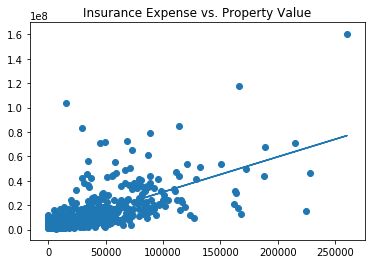

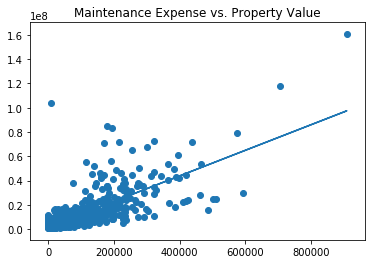

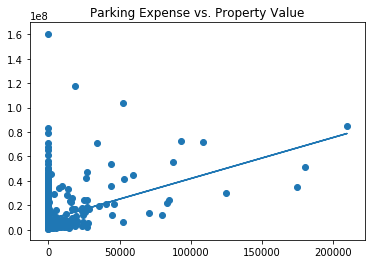

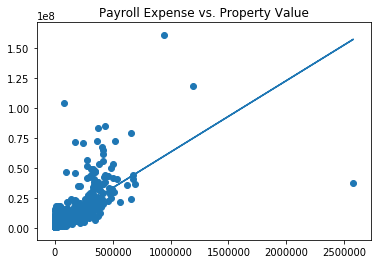

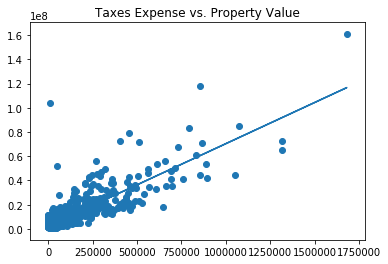

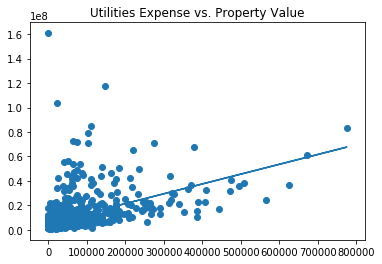

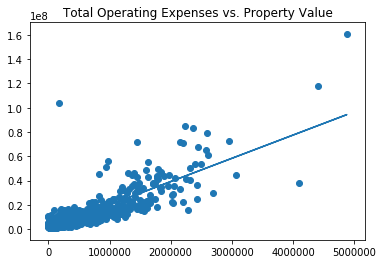

In [22]:
#Make all the plots
dora.plot_feature("Insurance Expense")
dora.plot_feature('Maintenance Expense')
dora.plot_feature('Parking Expense')
dora.plot_feature('Payroll Expense')
dora.plot_feature('Taxes Expense')
dora.plot_feature('Utilities Expense')
dora.plot_feature('Total Operating Expenses')

There do seem to be some economies of scale with regard to expenses. The clearest quadratic relationship, think $y = x^2$, that we can observe in the data can be seen in the payroll expenses. This makes intuitive sense because higher value buildings will tend to be higher density thus boosting productivity of building employees, e.g. a 1000-unit building doesn’t need twice the doormen as a 500-unit building.

The other categories of expenses don't seem to exhibit quadratic relationships. But these features seem to be highly heteroskedastic. It would be interesting to see how controlling for location, either through state or MSA, could reduce some of the underlying variance. Also, the parking expenses feature probably needs to have the zero values removed!

## Please	create	graphs	depicting	the	following.	Feel	free	to	use	any	tools	that	you	think	would	help

In [23]:
def make_expense_ratio(df):
    res = make_pct(df, "Total Operating Expenses", 'Effective Gross Income')
    return(res)

data3['expense_ratio'] = data3.apply(make_expense_ratio, axis=1)
data3['expense_ratio'].describe()

count    945.000000
mean       0.397674
std        0.143912
min        0.000000
25%        0.307045
50%        0.403261
75%        0.502610
max        0.949870
Name: expense_ratio, dtype: float64

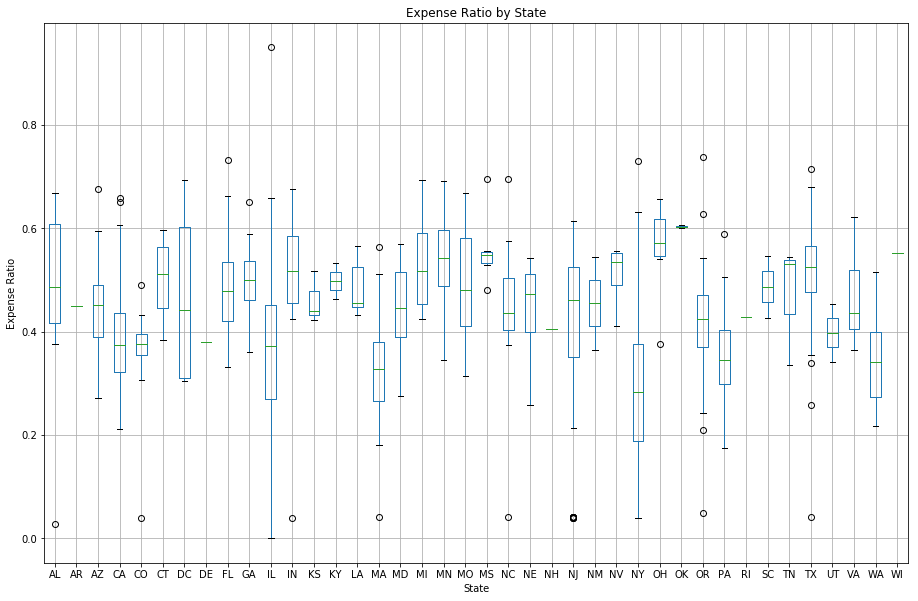

In [24]:
#Generate Chart
data3.boxplot(column="expense_ratio", 
              by="State",
             figsize = (15, 10))
#Make the titles and axes nice
plt.title("Expense Ratio by State")
plt.suptitle("")
plt.ylabel("Expense Ratio")
plt.show()

## Relationship	between	age	of	property	and	expenses

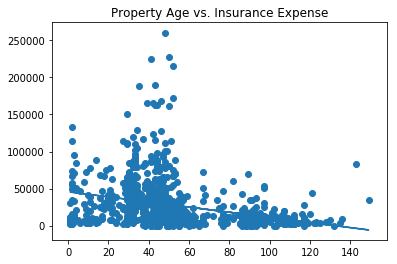

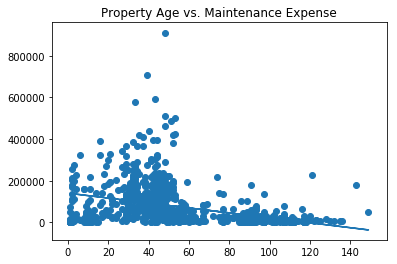

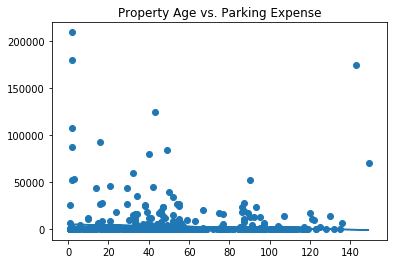

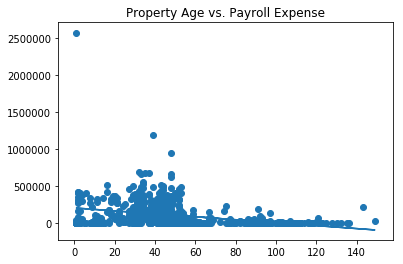

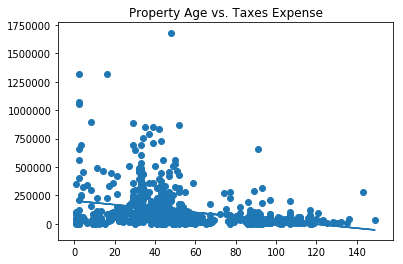

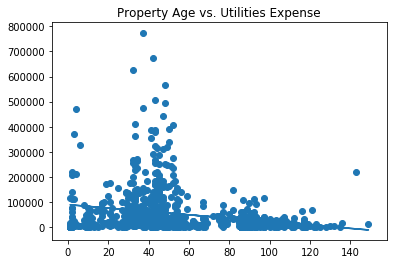

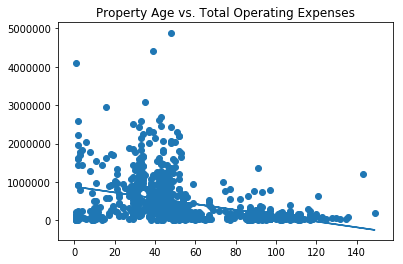

In [25]:
#define property age
data3['Property Age'] = 2017 - data3['Year Built']

#drop some bad columns
data3_prop_age = data3.loc[data3["Property Age"] >0]

#define the expnese columns
expenses = ["Insurance Expense",
            'Maintenance Expense',
            'Parking Expense',
            'Payroll Expense',
            'Taxes Expense',
            'Utilities Expense',
            'Total Operating Expenses']

#Dora is a great little package for data exploration. 
for expense in expenses:
    dora_prop_age = Dora(output=expense, data=data3_prop_age)
    dora_prop_age.plot_feature('Property Age')

## Cumulative	loan	amount	by	fiscal	quarter

In [26]:
from pandas.tseries.offsets import *
date =data3.sort_values('First Payment Date', ascending=True)
date = date.loc[date['First Payment Date'].isnull() == False]

date['quarter'] = date['First Payment Date'].dt.quarter
date['annual quarter'] = date.apply(lambda x:(x['First Payment Date'] + BQuarterBegin(x['quarter'])), axis=1)

#Check for loans that are maturing during our time horizon
def is_mature(df):
    if df["Maturity Date"] == df['First Payment Date']:
        res = -1
    else:
        res =1
    return(res)
date['is_mature'] = date.apply(is_mature, axis =1)
#ok, so all the loans that mature during our window have a loan amount of zero. Thanks, that makes this easier!
date[date['is_mature']==-1]


,First Payment Date,Maturity Date,Zip,State,Effective Gross Income,Insurance Expense,Loan Amount,Maintenance Expense,Net Operating Income,Parking Expense,...,maintenance_exp,loan_length_days,loan_length_months,loan_length_years,LTV,expense_ratio,Property Age,quarter,annual quarter,is_mature
818,2016-07-01,2016-07-01,90814,CA,211290.52,5849.62,0.0,6265.17,128233.88,0.0,...,0.001789,0.0,0.0,0.0,0.0,0.388133,55.0,3,2017-03-01,-1
817,2016-07-01,2016-07-01,90814,CA,120690.06,3443.73,0.0,5514.74,74518.19,0.0,...,0.003071,0.0,0.0,0.0,0.0,0.373260,54.0,3,2017-03-01,-1


In [27]:
#Going to do some funky groupings so i'll isolate a new date frame
date2 = date
date2.set_index(date['annual quarter'], inplace=True)
#get bounds on time window
date_info = date['annual quarter'].describe()
#timeseries groupings and cumulative sums, this one took some fiddiling and feels more like black magic than good code
date3=date2.loc[date_info['first'].date():date_info['last']]['Loan Amount'].reset_index()
cumulative_loans_by_qt = date3.groupby(by=['annual quarter']).sum().groupby(level=[0]).cumsum()


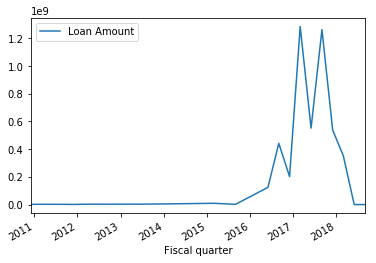

In [28]:
cumulative_loans_by_qt.index.name='Fiscal quarter'
cumulative_loans_by_qt.plot()


Wanted to note that the above graph is in nominal terms. We could improve the usefulness of this metric by discounting by the WACC and adjusting for inflation. 

## Using	Scikit-Learn	or	a	library of	your	choice,	create	a	model that	predicts	loan	to	value.	How	accurate	is	your	model?	

So having conducted a __[brief survey](http://mitsloan.mit.edu/media/Lo_ConsumerCreditRiskModels.pdf)__ __[of the literature](https://bfi.uchicago.edu/sites/default/files/file_uploads/Slides%20Giesecke.pdf)__, it appears that there is evidence of complex non-linear relationships between property characteristics and LTV ratios. From what we've seen of the data so far, I tend to support this idea. To account for this, we're going to need to use non-linear models. We don't have a lot of data to work with here, so I'm going to stay away from fancier ML techniques, such as NNs, which require more data to avoid overfitting. That pretty much leaves us with tree based models (I don't like using things like SVMs because they're too easy to get wrong). There are many different tree model packages, but I've had really good results working with XGBoost so I'll use it here. 

Normally I would use construct a k-folds cross validation set, but since we're dealing with less tha 1k records I dont want to reduce my sample size any more than I have to. So this model will simply be a train/test split.


In [29]:
#Read in packages needed to do the modeling
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor #note: Xcode doesnt support OpenMP multi-threading, which XGBoost uses. To fix this you run 'brew install gcc@5' in the terminal to fix.
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, explained_variance_score


#So I realized that I might want to run multiple data sets, I'm just going to make this into a function
def model_magic(df, target_col, bad_features, max_tree_depth):
    #remove bad features and drop rows with a null target
    model_data = df[df.columns.difference(bad_features)].dropna(axis=0, subset=[target_col])
    #we also want to remove any targets that have  LTV of 0. LTV=0 doesn't make any sense since we're giving them loans
    model_data2 = model_data.loc[model_data['LTV']>0]
    
    #split dataframe in to target and features
    target = model_data2[target_col]
    features = model_data2.drop([target_col], axis =1)
    #remove whitespace from feature names. Whitespace breaks xgboost for some reason
    features.columns = [c.replace(' ', '_') for c in features.columns]
    seed =4
    
    #so normally I would use construct a k-folds cross validation set, but since we're dealing with less tha 1k records I dont want to reduce my sample size any more than I have to. So this model will simply be a train/test split.
    feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=seed)
    
    #build the model
    model = XGBRegressor(max_depth=max_tree_depth)
    model.fit(feature_train, target_train)
    
    #make prediction
    target_pred = model.predict(feature_test)
    #get model scores
    r2 = r2_score(target_test, target_pred)
    mean_sq_error = mean_squared_error(target_test, target_pred)
    median_abs_error = median_absolute_error(target_test, target_pred)
    expl_var_score = explained_variance_score(target_test, target_pred)
    
    score_df  =pd.DataFrame({"R^2 Score": r2,
                             "Mean Squared Error": mean_sq_error,
                             "Median Absolute Error": median_abs_error},
                             index =["Model"]).transpose()
    return(score_df)

/Users/tdaly/miniconda3/envs/greystone/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
#Lets drop a description of LTV here for reference
ltv_desc = data3.loc[data3['LTV']>0]
print(ltv_desc['LTV'].dropna(axis=0).describe()) 
print(ltv_desc['LTV'].dropna(axis=0).describe()['std']**2)

count    809.000000
mean       0.641397
std        0.172528
min        0.027369
25%        0.607677
50%        0.685435
75%        0.758242
max        1.648376
Name: LTV, dtype: float64
0.0297659030406


In [31]:
#define features we don't want in our data
bad_features = ['First Payment Date',
                'Maturity Date',
                'Zip', 
                'Loan Amount',
                'Property Value',
                'Year Built',
                'tax_pct',
                'maintenance_exp',
                'loan_length_months', # We don't want collinear features, so we will remove the least powerful time vars 
                'loan_length_days',
                'State']
model_magic(data3, "LTV", bad_features=bad_features, max_tree_depth=3)

,Model
Mean Squared Error,0.018424
Median Absolute Error,0.085932
R^2 Score,0.107538


Ok, so this model is sort of a mixed bag. Our $R^2$ score, a measure of how well our model fits our data, is pretty low. Generally the closer to 1 we can get the $R^2$ score the better, so a score of $0.107538$ isn't great. On the other hand, our Mean Squared Error (MSE) is very low. MSE is a measure of how far off our average prediction is, so the closer we can get it to $0$ the better our model performs. The Median Absolute Error (MAE) is another measure a measure of how far off predictions are but because we're taking median of all the differences, it is robust to outliers. This suggests that our model is does a better job of making predictions on the tails of LTV distribution, but doesn't do as well of predicting LTV's closer to the median. 

Overall, this suggest that our data is noisy, lacks sufficient explanatory power, or both.

## What	would	be	required	to	improve	this	score?

The gimmie answer here is more data. Thankfully there is a lot of data floating around out there, but I think we can improve our model without having to go out and append additional data. We can use the State variable to try and control for some of the variance introduced by geography. 

In [32]:
bad_features = ['First Payment Date',
                'Maturity Date',
                'Zip', 
                'Loan Amount',
                'Property Value',
                'Year Built',
                'tax_pct',
                'maintenance_exp',
                'loan_length_months', # We don't want collinear features, so we will remove the least powerful time vars 
                'loan_length_days']
#extract ordinal features
data3_with_states = Dora(output="LTV", data=data3)
data3_with_states.extract_ordinal_feature("State")

#build new model
model_magic(data3_with_states.data, "LTV", bad_features=bad_features, max_tree_depth=3)

,Model
Mean Squared Error,0.015574
Median Absolute Error,0.072058
R^2 Score,0.245599


Wonderful! We've more than doubled the $R^2$ score of our model while reducing The MSE and MAE. This model still isn't performing all that well, but it definite improvement over the previous version. However, there are some additional problems. By extracting ordinal features, we've massively increased the number of features for consideration. This has probably led to some overfitting by our model. This isn't great, but without more data we are limited in what we can do to correct for this. 

But what do we need to get an even better model? I can think of a couple of things off the top of my head:

1. **More Records**: Our original data set only contains 967 records. This is limits us in a couple of ways. The most limiting factor to working with data this size is that our model may not be able to extract sufficient signal from noise. Another way this limits us is that we can't perform cross-validation on a data set of this size. Cross-validation would help us ward off some concerns about overfitting.

2. **More Features:** Adding additional features will allow us to identify additional signal and thus increase our model's predictive power. Here is a data wish list:
    * Collocated real estate data: What are the prices for multi-family buildings in the immediate area? What is the property's proximity to local amenities? 
    * Geographic Data: What are the neighborhood schools like? How walkable is the surrounding area? What sort of public transit is in the area?
    * Borrower Data: What is the credit score of the borrower? Is the borrower an individual or a person? What is the borrower's annual income? Are they projected to be profitable in the future?
    
3. **Time Series Data:** Basically all the data described in (2), but over time. Loan to Value ratio will change over time, so we want to be able to predict how property value will change over time. Being better able to predict property value would have beneficial business impacts as it would reduce future leverage, thus allowing us to write more loans. 

4. **Fill Missing Values:** This is pretty basic, but important. I understand that the missing values were probably included to see how I dealt with NaNs and such, but a loan company should keep *really* detailed records on things like property value.
